In [1]:
from typing import List
from collections import defaultdict

import pandas as pd

# Impacto novo regulamento da UFRN

A UFRN aprovou o [novo regulamento da graduação](https://www.ufrn.br/imprensa/noticias/72045/consepe-aprova-novo-regulamento-da-graduacao), modificando a estrutura de notas. Esse notebook investiga qual o impacto do novo regulamento utilizando os dados abertos da UFRN para verificar se mais pessoas serão reprovadas.

A notícia da UFRN diz "Também foram realizadas várias simulações envolvendo os novos critérios de rendimento e, considerando as notas atuais dos estudantes, não foram verificados impactos significativos em relação à reprovação". Vamos investigar se o número de aprovações se mantém com o novo regulamento, para isso vamos utilizar como amostra de dados o último semestre disponível na base de dados abertas: 2022.2

In [2]:
! wget https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/b159805b-e7cb-4d71-872b-14a1a2625d7e/download/matriculas-2022.2.csv --no-check-certificate

--2023-07-05 22:02:57--  https://dados.ufrn.br/dataset/c8650d55-3c5a-4787-a126-d28a4ef902a6/resource/b159805b-e7cb-4d71-872b-14a1a2625d7e/download/matriculas-2022.2.csv
Resolving dados.ufrn.br (dados.ufrn.br)... 177.20.146.38
Connecting to dados.ufrn.br (dados.ufrn.br)|177.20.146.38|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 67169203 (64M) [text/csv]
Saving to: ‘matriculas-2022.2.csv.1’

matriculas-2022.2.c 100%[===================>]  64.06M  11.2MB/s    in 5.7s    

2023-07-05 22:03:03 (11.2 MB/s) - ‘matriculas-2022.2.csv.1’ saved [67169203/67169203]



In [3]:
! wget wget https://dados.ufrn.br/dataset/02526b96-cf40-4507-90b0-3afe5ddd53e7/resource/a10bc434-9a2d-491a-ae8c-41cf643c35bc/download/cursos-de-graduacao.csv --no-check-certificate

--2023-07-05 22:03:03--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-07-05 22:03:04--  https://dados.ufrn.br/dataset/02526b96-cf40-4507-90b0-3afe5ddd53e7/resource/a10bc434-9a2d-491a-ae8c-41cf643c35bc/download/cursos-de-graduacao.csv
Resolving dados.ufrn.br (dados.ufrn.br)... 177.20.146.38
Connecting to dados.ufrn.br (dados.ufrn.br)|177.20.146.38|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 42144 (41K) [text/csv]
Saving to: ‘cursos-de-graduacao.csv.1’

cursos-de-graduacao 100%[===================>]  41.16K  --.-KB/s    in 0.002s  

2023-07-05 22:03:04 (16.8 MB/s) - ‘cursos-de-graduacao.csv.1’ saved [42144/42144]

FINISHED --2023-07-05 22:03:04--
Total wall clock time: 1.3s
Downloaded: 1 files, 41K in 0.002s (16.8 MB/s)


In [4]:
df_matriculas = pd.read_csv('matriculas-2022.2.csv', sep=';')
df_matriculas.head()

,id_turma,discente,id_curso,unidade,nota,reposicao,faltas_unidade,media_final,numero_total_faltas,descricao
0,57705399,1d568d48ce1a8b2ce4137e51abd0249a,2000005.0,1.0,"8,5",False,0.0,"8,7",0.0,APROVADO
1,57705399,1d568d48ce1a8b2ce4137e51abd0249a,2000005.0,2.0,"8,5",False,0.0,"8,7",0.0,APROVADO
2,57705399,1d568d48ce1a8b2ce4137e51abd0249a,2000005.0,3.0,"9,0",False,0.0,"8,7",0.0,APROVADO
3,57705399,5c30de64828a5c3e51e2a2428cb83165,2000005.0,1.0,"9,7",False,0.0,"9,6",0.0,APROVADO
4,57705399,5c30de64828a5c3e51e2a2428cb83165,2000005.0,2.0,"9,7",False,0.0,"9,6",0.0,APROVADO


Existem várias situações em que o discente pode se encontrar após a consolidação de uma disciplina. Abaixo são listados todas essas situações.

In [5]:
df_matriculas['descricao'].unique()

array(['APROVADO', 'DESISTENCIA', 'REPROVADO POR MÉDIA E POR FALTAS',
       'APROVADO POR NOTA', 'INDEFERIDO', 'TRANCADO', 'REPROVADO',
       'CANCELADO', 'EXCLUIDA', 'REPROVADO POR FALTAS',
       'REPROVADO POR NOTA E FALTA', 'REPROVADO POR NOTA', 'MATRICULADO',
       'DISPENSADO', 'EM ESPERA', 'AGUARDANDO DEFERIMENTO', 'CUMPRIU'],
      dtype=object)

Vamos investigar o impacto no novo regulamento sobre quem foi `Aprovado por Nota` (que pelo regulamento antigo teve média 5.0 com notas acima de 3.0 em cada unidade)

In [6]:
df_aprovados_nota = df_matriculas[df_matriculas['descricao'] == 'APROVADO POR NOTA'] 
len(df_aprovados_nota)

96129

É possível notar que 96129 matrículas constam como `Aprovado por Nota`. Vale ressaltar que esse número não é a real quantidade de aprovações por nota, uma vez que esses dados replicam as notas das unidades pagas pelo discente, então se uma disciplina tem 3 unidades o status de `Aprovado por Nota` aparece três vezes.

Para saber o real número de aprovações por nota vamos agrupar os dados por discente, turma e as unidades dessa disciplina.

In [7]:
df_aprovados_nota_grupo = df_aprovados_nota.groupby(by=['discente', 'id_turma', 'id_curso','unidade'])
df_aprovados_nota_grupo.first()

nota reposicao  \
discente                         id_turma id_curso  unidade                  
000098dc4f9897eccba03c5b1e9fb49a 57708907 2000122.0 1.0      6,7     False   
                                                    2.0      5,6     False   
                                                    3.0      5,2     False   
0000ad2567692a566a6d6f701eb9b161 57707687 2000014.0 1.0      6,0     False   
                                                    2.0      7,0     False   
...                                                          ...       ...   
fffc43b492fcefa5b99f7b6469834861 57707185 2000039.0 2.0      6,6     False   
                                                    3.0      5,3     False   
                                 57707214 2000039.0 1.0      5,2     False   
                                                    2.0      6,7     False   
                                                    3.0      5,7     False   

                                                             faltas_unidade  \
discente                         id_turma id_curso  unidade                   
000098dc4f9897eccba03c5b1e9fb49a 57708907 2000122.0 1.0                 0.0   
                                                    2.0                 0.0   
                                                    3.0                 0.0   
0000ad2567692a566a6d6f701eb9b161 57707687 2000014.0 1.0                 0.0   
                                                    2.0                 0.0   
...                                                                     ...   
fffc43b492fcefa5b99f7b6469834861 57707185 2000039.0 2.0                 0.0   
                                                    3.0                 0.0   
                                 57707214 2000039.0 1.0                 0.0   
                                                    2.0                 0.0   
                                                    3.0                 0.0   

                                                            media_final  \
discente                         id_turma id_curso  unidade               
000098dc4f9897eccba03c5b1e9fb49a 57708907 2000122.0 1.0             5,8   
                                                    2.0             5,8   
                                                    3.0             5,8   
0000ad2567692a566a6d6f701eb9b161 57707687 2000014.0 1.0             6,5   
                                                    2.0             6,5   
...                                                                 ...   
fffc43b492fcefa5b99f7b6469834861 57707185 2000039.0 2.0             6,1   
                                                    3.0             6,1   
                                 57707214 2000039.0 1.0             5,9   
                                                    2.0             5,9   
                                                    3.0             5,9   

                                                             numero_total_faltas  \
discente                         id_turma id_curso  unidade                        
000098dc4f9897eccba03c5b1e9fb49a 57708907 2000122.0 1.0                     14.0   
                                                    2.0                     14.0   
                                                    3.0                     14.0   
0000ad2567692a566a6d6f701eb9b161 57707687 2000014.0 1.0                     14.0   
                                                    2.0                     14.0   
...                                                                          ...   
fffc43b492fcefa5b99f7b6469834861 57707185 2000039.0 2.0                      4.0   
                                                    3.0                      4.0   
                                 57707214 2000039.0 1.0                      2.0   
                                                    2.0                      2.0   
                                 

É possível notar que o impacto desse novo regulamento se daria sobre `65071` aprovações por nota de `2022.2`. Mas qual será o impacto? Para medir isso vamos reprocessar as notas com o novo regulamento e ver quantos estudantes continuam se enquadrando na situação de `Aprovados por nota`.

In [8]:
def unidades_acima_quatro(notas: List[float]) -> bool:
    return all([nota >= 4.0 for nota in notas])

def media_acima_seis(notas: List[float]) -> bool:
    media = sum([nota for nota in notas])/len(notas)
    return media >= 6.0

Para facilitar o processamento vamos modificar a estrutura de dados para um dicionário python no formato: `{(discente, turma): [nota unidade 1, nota unidade 2, ..., nota unidade x]`

In [9]:
preprocessamento_afetados = defaultdict(lambda: [])

In [10]:
for (discente, turma, curso, unidade), group in df_aprovados_nota_grupo:
    nota = float(group['nota'].iloc[0].replace(',', '.'))
    preprocessamento_afetados[(discente, turma, curso)].append(nota)

In [11]:
df_cursos = pd.read_csv("cursos-de-graduacao.csv", delimiter=';')
df_cursos.head()

,id_curso,nome,id_coordenador,coordenador,situacao_curso,nivel_ensino,grau_academico,modalidade_educacao,area_conhecimento,tipo_oferta,...,municipio,campus,id_unidade_responsavel,unidade_responsavel,website,data_funcionamento,codigo_inep,dou,portaria_reconhecimento,convenio_academico
0,2000004,ADMINISTRAÇÃO,5752389.0,MARILENE BIZERRA DA COSTA,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Sociais Aplicadas,Regular,...,CURRAIS NOVOS,Campus Currais Novos,31011,"FACULDADE DE ENGENHARIA, LETRAS E CIÊNCIAS SOC...",NaN,1978/09/15 00:00:00.000,12355.0,2017/04/04 00:00:00.000,Portaria nº 272/2017 - MEC,NaN
1,2000002,ADMINISTRAÇÃO,24344.0,CARLOS ALBERTO FREIRE MEDEIROS,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Sociais Aplicadas,Regular,...,NATAL,Campus Central,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS,http://sol.ccsa.ufrn.br/ccsa/areas/adm/adminis...,1971/09/16 00:00:00.000,12311.0,2017/04/04 00:00:00.000,Portaria nº 272/2017 - MEC,NaN
2,149654895,ADMINISTRAÇÃO PÚBLICA,5756268.0,ANTONIO ALVES FILHO,ATIVO,GRADUAÇÃO,BACHARELADO,Presencial,Ciências Sociais Aplicadas,Regular,...,NATAL,NaN,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS,NaN,NaN,1563343.0,NaN,NaN,NaN
3,15315770,ADMINISTRAÇÃO PÚBLICA,5753587.0,CARLOS DAVID CEQUEIRA FEITOR,ATIVO,GRADUAÇÃO,BACHARELADO,A Distância,Ciências Sociais Aplicadas,Regular,...,NATAL,NaN,443,CENTRO DE CIÊNCIAS SOCIAIS APLICADAS,NaN,NaN,1151028.0,2014/04/11 00:00:00.000,Portaria nº 226/2014 - DIREG/MEC,NaN
4,94598200,ANÁLISE E DESENVOLVIMENTO DE SISTEMAS,5760230.0,CARLA DA COSTA FERNANDES CURVELO,ATIVO,GRADUAÇÃO,TECNOLÓGICO,Presencial,Outra,Anual,...,MACAÍBA,NaN,351,ESCOLA AGRÍCOLA DE JUNDIAÍ,NaN,NaN,1188193.0,2018/12/28 00:00:00.000,Portaria MEC/SERES Nº 922/2018,NaN


In [12]:
reprovados_por_curso = {}
for (curso, nome) in zip(df_cursos['id_curso'], df_cursos['nome']):
    reprovados_por_curso[curso ] = [nome, 0]

aprovados_novo_regulamento = 0
for (discente, turma, curso), notas in preprocessamento_afetados.items():
    if unidades_acima_quatro(notas) and media_acima_seis(notas):
        aprovados_novo_regulamento += 1
    else :
        reprovados_por_curso[int(curso)][1] += 1


Com o calculo anterior podemos concluir que o seguinte número de aprovações deixariam de existir:

In [13]:
len(df_aprovados_nota_grupo) - aprovados_novo_regulamento

55713

In [14]:
reprovados_por_curso_ordenado_por_reprovacoes = sorted(reprovados_por_curso.values(), key=lambda r: r[1], reverse=True)

In [15]:
cursos = [r[0] for r in reprovados_por_curso_ordenado_por_reprovacoes]
reprovados = [r[1] for r in reprovados_por_curso_ordenado_por_reprovacoes]

Abaixo podemos ver em quais cursos esses novo reprovados estão localizados.
  Podemos destacar Ciência e tecnologia com mais de 2000 novos reprovados

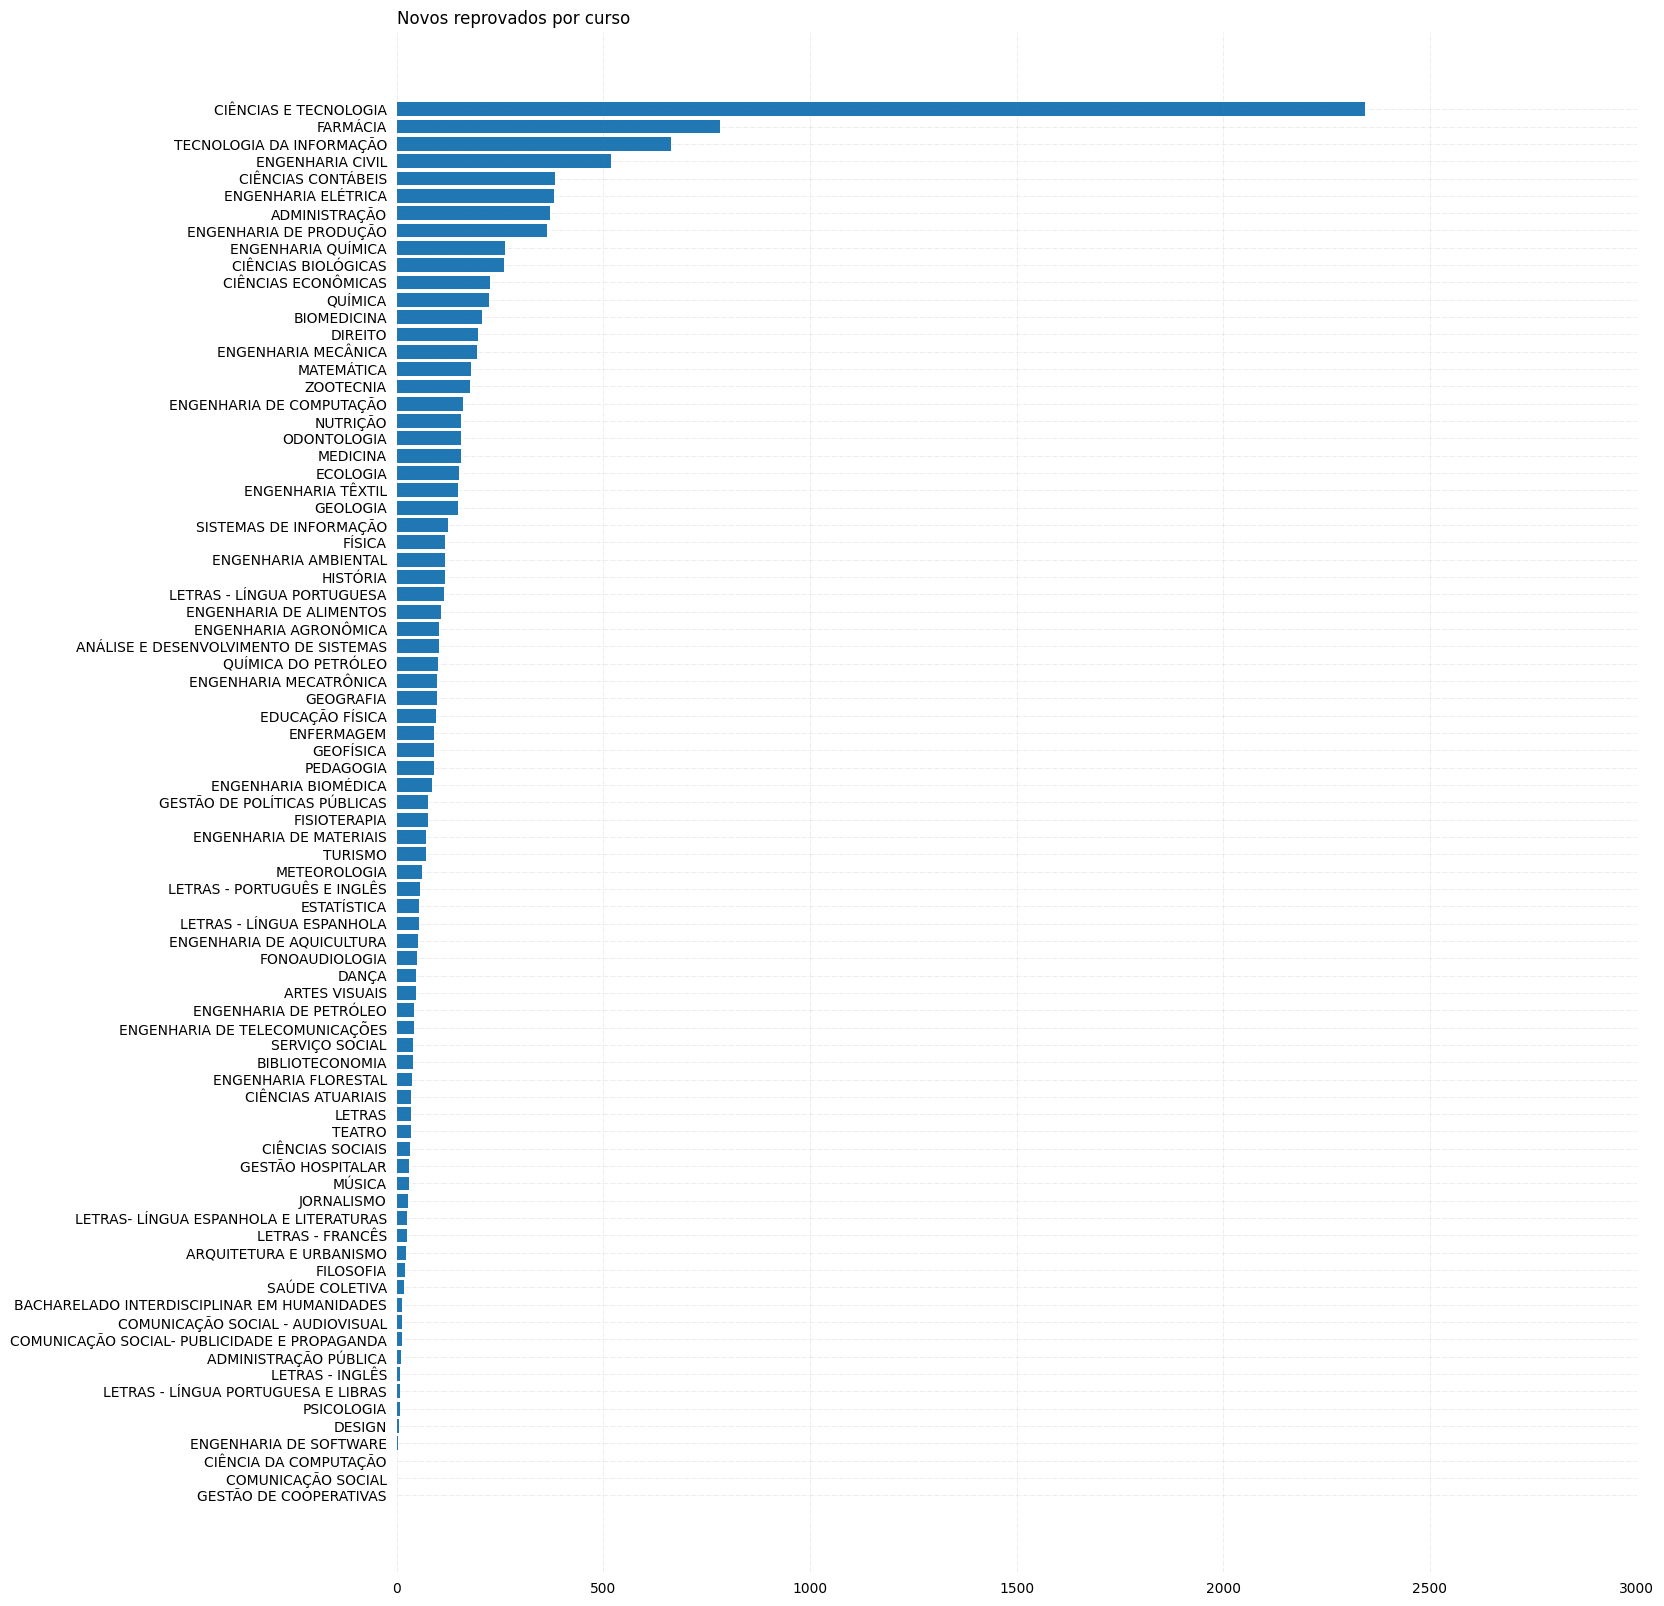

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize =(16, 20))

ax.barh(cursos, reprovados)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


ax.invert_yaxis()

ax.set_xbound(lower=0, upper=3000)

ax.set_title('Novos reprovados por curso',
             loc ='left', )

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

plt.show()